In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [ ]:
import tempfile
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.1.post1


In [ ]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

# --- Google Drive and Path Definitions (keep your existing, correct path logic) ---
import os
from google.colab import drive # Ensure this is imported

try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise # Stop if drive cannot be mounted

# Define the path to YOUR processed H5AD file
# This should point to the output of your preprocessing script (Block 8 from our previous discussion)
# For example, if you saved it as "pbmc10k_cite_seq_processed_for_totalVI.h5ad"
# in your 'processed_data_dir'
gdrive_base_path = '/content/drive/My Drive/CMML_ICA2/' # Your main project folder
# Directory where your processed H5AD file is located
processed_data_dir = os.path.join(gdrive_base_path, 'data_pbmc10k_mtx/processed/') # Path from your previous successful save
your_processed_h5ad_filename = "pbmc10k_cite_seq_processed_for_totalVI.h5ad" # The name of your H5AD file
path_to_your_h5ad = os.path.join(processed_data_dir, your_processed_h5ad_filename)

print(f"Attempting to load processed AnnData from: {path_to_your_h5ad}")

Mounted at /content/drive
Google Drive mounted successfully.
Attempting to load processed AnnData from: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/pbmc10k_cite_seq_processed_for_totalVI.h5ad


In [ ]:
# --- Load YOUR processed H5AD file ---
try:
    # adata = scvi.data.pbmcs_10x_cite_seq(save_path=gdrive_save_path) # OLD LINE - REMOVE OR COMMENT OUT

    # NEW LINE: Load your preprocessed H5AD file
    if os.path.exists(path_to_your_h5ad):
        adata_main_filtered = sc.read_h5ad(path_to_your_h5ad) # Use scanpy.read_h5ad
        print("Successfully loaded your processed H5AD file.")
        print("Loaded AnnData object (adata_main_filtered):")
        print(adata_main_filtered)
        # You should see the obs, var, obsm, layers, uns that you saved in your preprocessing script
        if "protein_counts" in adata_main_filtered.obsm:
            print(f"  protein_counts shape: {adata_main_filtered.obsm['protein_counts'].shape}")
        if "ground_truth_cell_type" in adata_main_filtered.obs:
            print("  'ground_truth_cell_type' found in .obs.")
            print(adata_main_filtered.obs["ground_truth_cell_type"].value_counts().head())
        if "counts" in adata_main_filtered.layers:
            print("  'counts' layer found.")
    else:
        print(f"ERROR: Your processed H5AD file was not found at {path_to_your_h5ad}")
        print("Please ensure the path and filename are correct and the preprocessing script (Block 8) ran successfully.")
        adata_main_filtered = None # Set to None if loading failed
except Exception as e:
    print(f"Error loading your processed H5AD file: {e}")
    adata_main_filtered = None
    import traceback
    traceback.print_exc()


# --- Inline backend config (keep this) ---
# %config InlineBackend.print_figure_kwargs={"facecolor": "w"}
# %config InlineBackend.figure_format="retina"

# --- Check if data loaded successfully before proceeding ---
if adata_main_filtered is None or adata_main_filtered.n_obs == 0:
    print("\nCRITICAL ERROR: Data loading failed or resulted in an empty AnnData object. Cannot proceed.")
else:
    print("\nData loading section complete. adata_main_filtered is ready.")

Successfully loaded your processed H5AD file.
Loaded AnnData object (adata_main_filtered):
AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'protein_names'
    obsm: 'protein_counts'
    layers: 'counts'
  protein_counts shape: (7611, 17)
  'ground_truth_cell_type' found in .obs.
ground_truth_cell_type
CD4+ T cells       2433
CD14+ monocytes    1555
CD8+ T cells       1087
unknown            1072
NK cells            807
Name: count, dtype: int64
  'counts' layer found.

Data loading section complete. adata_main_filtered is ready.


In [ ]:
adata = adata_main_filtered.copy()
adata

AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'protein_names'
    obsm: 'protein_counts'
    layers: 'counts'

In [ ]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

In [ ]:
protein_adata = ad.AnnData(adata.obsm["protein_counts"])
protein_adata.obs_names = adata.obs_names
del adata.obsm["protein_counts"]
mdata = md.MuData({"rna": adata, "protein": protein_adata})
mdata

/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 7611 × 17951
  2 modalities
    rna:	7611 x 17934
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'
    protein:	7611 x 17

In [ ]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][:, mdata.mod["rna"].var["highly_variable"]].copy()

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [ ]:
mdata.update()

/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_com

In [ ]:
mdata

MuData object with n_obs × n_vars = 7611 × 21951
  3 modalities
    rna:	7611 x 17934
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'
    protein:	7611 x 17
    rna_subset:	7611 x 4000
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'

In [ ]:
adata

AnnData object with n_obs × n_vars = 7611 × 17934
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'protein_names'
    layers: 'counts'

In [ ]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    #batch_key="batch",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [ ]:
model = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [ ]:
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_worker

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1217.552. Signaling Trainer to stop.


In [ ]:
model_save_path = os.path.join(gdrive_base_path, "totalVI_pbmc_model")
model.save(model_save_path, overwrite=True)
print(f"totalVI model saved to: {model_save_path}")

# loaded_model = scvi.model.TOTALVI.load(model_save_path, adata=mdata)

totalVI model saved to: /content/drive/My Drive/CMML_ICA2/totalVI_pbmc_model


<ipython-input-28-23f2ca376595>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_max_loss_float = float(last_max_loss)


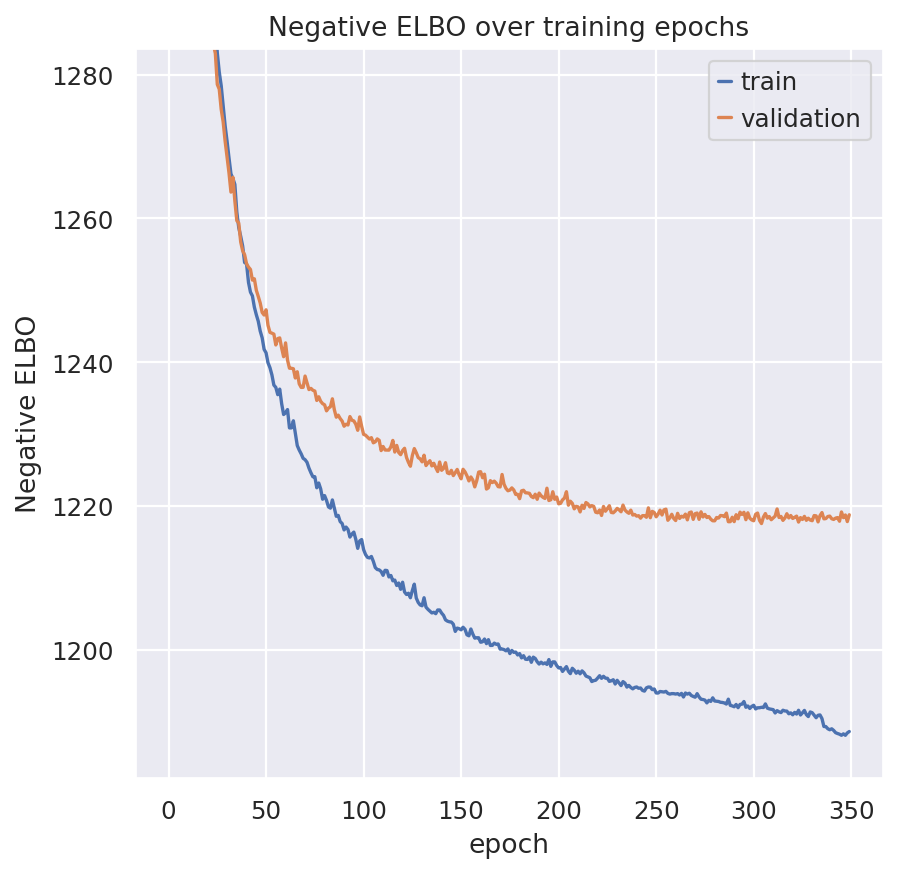

ELBO plot saved to /content/drive/My Drive/CMML_ICA2/totalVI_elbo_curves.png


In [ ]:
# Ensure history values are simple lists of floats or pandas Series
# model.history["elbo_train"] and model.history["elbo_validation"]
# are typically pandas Series after training if accessed directly.
# If they are lists of tensors, you would need to convert them.
# Let's assume they are pandas Series or convertible to them for min/max.

# For robustness, convert to numpy arrays of floats if they are not already
try:
    # If model.history values are DataFrames or Series from scvi's history tracking
    elbo_train_values = model.history["elbo_train"].values.astype(float)
    elbo_val_values = model.history["elbo_validation"].values.astype(float)
except AttributeError:
    # If they are lists of tensors or simple floats
    elbo_train_values = np.array([v.item() if hasattr(v, 'item') else float(v) for v in model.history["elbo_train"]]).astype(float)
    elbo_val_values = np.array([v.item() if hasattr(v, 'item') else float(v) for v in model.history["elbo_validation"]]).astype(float)


if len(elbo_train_values) == 0 or len(elbo_val_values) == 0:
    print("ERROR: Training history is empty. Cannot plot ELBO curves.")
    # Handle this error, maybe skip plotting
else:
    last_val_train = elbo_train_values[-1]
    last_val_valid = elbo_val_values[-1]

    global_min_loss_train = np.min(elbo_train_values)
    global_min_loss_val = np.min(elbo_val_values)
    global_min_loss = min(global_min_loss_train, global_min_loss_val)

    # last_max_loss should be the maximum of the *last* training and validation losses
    last_max_loss = max(last_val_train, last_val_valid) # REMOVED [0]

    global_max_loss_train = np.max(elbo_train_values)
    global_max_loss_val = np.max(elbo_val_values)
    global_max_loss = max(global_max_loss_train, global_max_loss_val)

    # Compute the min and max for y-axis limits
    # min_loss for ylim should be based on the overall minimum observed
    min_loss_for_ylim = global_min_loss
    # max_loss for ylim should be based on overall maximum, but the original logic tried to zoom in
    # Let's simplify the ylim calculation slightly for clarity, or use the original logic if it was intended for specific zooming.

    # Original zooming logic:
    # ylim_min = 0.995 * min_loss_for_ylim
    # ylim_max = min(global_max_loss, ylim_min + (last_max_loss - ylim_min) * 4)

    # Simpler approach (full range, or slightly zoomed):
    plot_min_val = np.min(elbo_val_values[10:]) # Ignore first few noisy epochs for validation min for zooming
    plot_min_train = np.min(elbo_train_values[10:])
    ylim_min_plot = 0.995 * min(plot_min_val, plot_min_train) # Zoom in on the converged part

    # Use a reasonable upper bound, e.g., the max of the later part of validation or slightly above last values
    # Or cap by the initial high values if they are very large.
    # The original ylim_max logic was a bit complex to ensure the initial steep drop doesn't make the converged part too flat.
    # Let's try to replicate the original intent more cleanly if possible or use a simpler zoom.

    # Re-evaluating original ylim logic:
    # It seems designed to show the converged part well, while still hinting at earlier values.
    # Ensure all components are float
    ylim_min = 0.995 * float(min_loss_for_ylim)
    # Ensure last_max_loss and global_max_loss are floats for the calculation below
    last_max_loss_float = float(last_max_loss)
    global_max_loss_float = float(global_max_loss)

    # Cap the upper limit to avoid extreme early values dominating the scale
    # Consider the maximum of the later half of the validation loss as a sensible upper bound for the "zoomed" view
    if len(elbo_val_values) > 20: # Ensure there are enough points
        sensible_upper_bound = np.max(elbo_val_values[len(elbo_val_values)//2:]) * 1.05 # 5% above max of later half
    else:
        sensible_upper_bound = global_max_loss_float * 1.05

    ylim_max_candidate = ylim_min + (last_max_loss_float - ylim_min) * 4
    ylim_max = min(sensible_upper_bound, ylim_max_candidate, global_max_loss_float) # Ensure it doesn't exceed global max

    # Ensure ylim_min is less than ylim_max
    if ylim_min >= ylim_max:
        print("Warning: ylim_min >= ylim_max. Plotting full y-axis range instead.")
        ylim_min = None # Let matplotlib auto-scale
        ylim_max = None


    # --- Plotting (should work now if ylim_min/max are proper floats) ---
    fig, ax = plt.subplots(1, 1)
    # Plot using the processed numpy arrays directly if pandas Series plotting causes issues
    epochs_train = np.arange(len(elbo_train_values))
    epochs_val = np.arange(len(elbo_val_values))

    ax.plot(epochs_train, elbo_train_values, label="train")
    ax.plot(epochs_val, elbo_val_values, label="validation")

    ax.set_title("Negative ELBO over training epochs")
    ax.set_xlabel("epoch") # Add x-axis label
    ax.set_ylabel("Negative ELBO") # Add y-axis label
    if ylim_min is not None and ylim_max is not None:
        ax.set_ylim(ylim_min, ylim_max)
    ax.legend()
    plt.show() # Display the plot

    # Save the figure
    elbo_plot_path = os.path.join(gdrive_base_path, "totalVI_elbo_curves.png") # Use your gdrive_save_path
    fig.savefig(elbo_plot_path, dpi=300, bbox_inches='tight')
    print(f"ELBO plot saved to {elbo_plot_path}")

In [ ]:
adata_totalVI_latent = model.get_latent_representation()
mdata.obsm["X_totalVI"] = adata_totalVI_latent
mdata.write_h5mu(os.path.join(gdrive_base_path, "pbmc_mdata_with_totalVI_latent.h5mu"))
print("MuData object with totalVI latent space saved.")

MuData object with totalVI latent space saved.


/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]
#rna = mdata1.mod["rna_subset"]
#protein = mdata1.mod["protein"]

In [ ]:
# arbitrarily store latent in rna modality
TOTALVI_LATENT_KEY = "X_totalVI"
rna.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

In [ ]:
rna_denoised, protein_denoised = model.get_normalized_expression(n_samples=25, return_mean=True)
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers["protein_foreground_prob"] = 100 * model.get_protein_foreground_probability(
    n_samples=25, return_mean=True
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()
#mdata1.update()

/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_com

In [ ]:
mdata_processed_path = os.path.join(gdrive_base_path, "mdata_processed_totalVI.h5mu")
mdata.write_h5mu(mdata_processed_path)
print(f"Processed MuData object saved to: {mdata_processed_path}")

Processed MuData object saved to: /content/drive/My Drive/CMML_ICA2/mdata_processed_totalVI.h5mu


/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY, key_added="totalVI_neighbors_rna")
sc.tl.umap(rna, neighbors_key="totalVI_neighbors_rna", min_dist=0.3)
sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY, neighbors_key="totalVI_neighbors_rna", resolution=0.5)
mdata.update()


<ipython-input-34-117cfead9a86>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY, neighbors_key="totalVI_neighbors_rna", resolution=0.5)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudat

In [ ]:
umap_basis_key_muon = "rna_subset:X_umap"
ground_truth_color_key_muon = "rna_subset:ground_truth_cell_type"

if "rna_subset" not in mdata.mod:
    print("ERROR: Modality 'rna_subset' not found in mdata.")
elif "X_umap" not in mdata.mod["rna_subset"].obsm:
    print("ERROR: Basis 'X_umap' not found in mdata.mod['rna_subset'].obsm.")
    print("  Available obsm keys in rna_subset:", list(mdata.mod["rna_subset"].obsm.keys()))
elif "ground_truth_cell_type" not in mdata.mod["rna_subset"].obs:
    print("ERROR: Color key 'ground_truth_cell_type' not found in mdata.mod['rna_subset'].obs.")
    print("  Available obs keys in rna_subset:", mdata.mod["rna_subset"].obs.columns.tolist())
else:
    umap_gt_path = os.path.join(gdrive_base_path, "totalVI_umap_by_ground_truth_muon.png") # Use your figure_dir
    plt.figure(figsize=(8, 7)) # Adjust figsize for legend if needed
    muon.pl.embedding(
        mdata,
        basis=umap_basis_key_muon,
        color=ground_truth_color_key_muon,
        title="totalVI UMAP by Ground Truth Cell Type (Muon)",
        show=False,
        frameon=False,
        legend_loc="on data" if mdata.mod["rna_subset"].obs["ground_truth_cell_type"].nunique() < 28 else "right margin",
        legend_fontsize=8 # Adjust legend fontsize
    )
    plt.savefig(umap_gt_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"UMAP by Ground Truth (using Muon) saved to {umap_gt_path}")

UMAP by Ground Truth (using Muon) saved to /content/drive/My Drive/CMML_ICA2/totalVI_umap_by_ground_truth_muon.png


<Figure size 640x560 with 0 Axes>

In [ ]:
mdata

MuData object with n_obs × n_vars = 7611 × 21951
  obs:	'_scvi_labels'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  obsm:	'X_totalVI'
  3 modalities
    rna:	7611 x 17934
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'
    protein:	7611 x 17
      obs:	'_scvi_batch'
      var:	'clean_names'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	7611 x 4000
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type', '_scvi_batch', 'leiden_totalVI'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names', 'totalVI_neighbors_rna', 'umap', 'leiden_totalVI', 'rna_subset:ground_truth_cell_type_colors'
      obsm:	'X_totalVI', 'X_umap'
      layers:	'counts', 'denoised_rna'
      obsp:	'totalVI_neighbors_rna_distances', 'totalVI_neighbors_rna_connectivities'

In [ ]:
# Block for Visualizing and Saving Leiden Clustering Results (Revised)

import matplotlib.pyplot as plt # Ensure plt is imported
import pandas as pd # Ensure pandas is imported
import muon # Ensure muon is imported for plotting

leiden_resolution = 0.5 # This was the resolution used
umap_leiden_path = os.path.join(gdrive_base_path, "totalVI_umap_by_leiden_muon.png") # Use your figure_dir
plt.figure(figsize=(8, 7)) # Adjusted figsize

# Define keys for muon plotting
umap_basis_for_leiden_plot = "rna_subset:X_umap" # UMAP coordinates from rna_subset modality
leiden_color_for_plot = "rna_subset:leiden_totalVI" # Leiden labels from rna_subset modality

# Check if these keys/paths are valid in your mdata object
plot_leiden_map = True
if "rna_subset" not in mdata.mod:
    print("ERROR: Modality 'rna_subset' not found.")
    plot_leiden_map = False
if plot_leiden_map and "X_umap" not in mdata.mod["rna_subset"].obsm:
    print(f"ERROR: Basis 'X_umap' not found in mdata.mod['rna_subset'].obsm. Available: {list(mdata.mod['rna_subset'].obsm.keys())}")
    plot_leiden_map = False
if plot_leiden_map and "leiden_totalVI" not in mdata.mod["rna_subset"].obs:
    print(f"ERROR: Color key 'leiden_totalVI' not found in mdata.mod['rna_subset'].obs. Available: {mdata.mod['rna_subset'].obs.columns.tolist()}")
    plot_leiden_map = False

if plot_leiden_map:
    muon.pl.embedding(
        mdata,
        basis=umap_basis_for_leiden_plot,
        color=leiden_color_for_plot,
        title=f"totalVI UMAP by Leiden (res={leiden_resolution}, Muon)",
        show=False,
        frameon=False,
        legend_loc="on data", # legend directly on clusters
        legend_fontsize=8 # Adjust as needed
    )
    plt.savefig(umap_leiden_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"UMAP by Leiden clusters (using Muon) saved to {umap_leiden_path}")
else:
    print("Skipping UMAP by Leiden plot due to missing data.")


if "leiden_totalVI" in mdata.obs:
    totalvi_leiden_labels_df = pd.DataFrame({
        "cell_barcode": mdata.obs_names, # Global obs_names
        "leiden_totalVI": mdata.obs["leiden_totalVI"] # Global leiden_totalVI
    })
    leiden_labels_save_path = os.path.join(processed_data_dir, "totalVI_leiden_labels.csv")
    totalvi_leiden_labels_df.to_csv(leiden_labels_save_path, index=False)
    print(f"totalVI Leiden cluster labels saved to {leiden_labels_save_path}")
else:
    print("ERROR: 'leiden_totalVI' not found in mdata.obs. Cannot save labels.")

mdata_final_save_path = os.path.join(gdrive_base_path, "pbmc_mdata_with_totalVI_latent_umap_leiden.h5mu") # Use your gdrive_base_path
try:
    mdata.write_h5mu(mdata_final_save_path) # Removed overwrite=True, as you might not want to overwrite if it's the first save here
    print(f"MuData object with UMAP and Leiden results saved to {mdata_final_save_path}")
except Exception as e:
    print(f"Error saving final MuData object: {e}")

UMAP by Leiden clusters (using Muon) saved to /content/drive/My Drive/CMML_ICA2/totalVI_umap_by_leiden_muon.png
ERROR: 'leiden_totalVI' not found in mdata.obs. Cannot save labels.
MuData object with UMAP and Leiden results saved to /content/drive/My Drive/CMML_ICA2/pbmc_mdata_with_totalVI_latent_umap_leiden.h5mu


/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.11/dist-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


<Figure size 640x560 with 0 Axes>

In [ ]:
mdata

MuData object with n_obs × n_vars = 7611 × 21951
  obs:	'_scvi_labels'
  uns:	'_scvi_uuid', '_scvi_manager_uuid'
  obsm:	'X_totalVI'
  3 modalities
    rna:	7611 x 17934
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names'
      layers:	'counts'
    protein:	7611 x 17
      obs:	'_scvi_batch'
      var:	'clean_names'
      layers:	'denoised_protein', 'protein_foreground_prob'
    rna_subset:	7611 x 4000
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_protein_counts', 'n_proteins', 'ground_truth_cell_type', '_scvi_batch', 'leiden_totalVI'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg', 'log1p', 'protein_names', 'totalVI_neighbors_rna', 'umap', 'leiden_totalVI', 'rna_subset:ground_truth_cell_type_colors', 'rna_subset:leiden_totalVI_colors'
      obsm:	'X_totalVI', 'X_umap'
      layers:	'counts', 'denoised_rna'
      obsp:	'totalVI_neighbors_rna_distances', 'totalVI_neighbors_rna_connectivities'

In [ ]:
# Block for Saving PREVIOUSLY COMPUTED Denoised Expressions from MuData

import pandas as pd # Ensure pandas is imported
import os # Ensure os is imported

# --- Ensure your mdata object is loaded and up-to-date ---
# If you are in a new session or notebook, load the mdata object first:
# mdata_final_path = os.path.join(gdrive_base_path, "pbmc_mdata_with_totalVI_latent_umap_leiden.h5mu")
# if os.path.exists(mdata_final_path):
#     print(f"Loading MuData object from: {mdata_final_path}")
#     mdata = md.read_h5mu(mdata_final_path)
# else:
#     print(f"ERROR: MuData file not found at {mdata_final_path}. Cannot proceed to save denoised data.")
#     # Stop execution or handle error

print("\n--- Extracting and Saving Denoised Expressions from existing MuData layers ---")

# Paths for saving CSV files (ensure processed_data_dir is defined from Block 1)
denoised_rna_hvg_save_path = os.path.join(processed_data_dir, "totalVI_denoised_rna_hvg_from_layer.csv")
denoised_protein_save_path = os.path.join(processed_data_dir, "totalVI_denoised_protein_from_layer.csv")

# 1. Extract and save Denoised RNA (from rna_subset modality's layer)
if "rna_subset" in mdata.mod and "denoised_rna" in mdata.mod["rna_subset"].layers:
    # .layers["denoised_rna"] should be a DataFrame or AnnData view that can be converted
    denoised_rna_df = pd.DataFrame(
        data=mdata.mod["rna_subset"].layers["denoised_rna"], # This should be cells x genes
        index=mdata.mod["rna_subset"].obs_names,
        columns=mdata.mod["rna_subset"].var_names
    )
    denoised_rna_df.to_csv(denoised_rna_hvg_save_path)
    print(f"Denoised HVG RNA expression (from layer) saved to: {denoised_rna_hvg_save_path}")
    print(f"  Shape of saved denoised RNA: {denoised_rna_df.shape}")
else:
    print("ERROR: 'denoised_rna' layer not found in 'rna_subset' modality of mdata.")

# 2. Extract and save Denoised Protein (from protein modality's layer)
if "protein" in mdata.mod and "denoised_protein" in mdata.mod["protein"].layers:
    denoised_protein_df = pd.DataFrame(
        data=mdata.mod["protein"].layers["denoised_protein"], # This should be cells x proteins
        index=mdata.mod["protein"].obs_names,
        columns=mdata.mod["protein"].var_names # Or mdata.mod["protein"].var["clean_names"] if you prefer
    )
    denoised_protein_df.to_csv(denoised_protein_save_path)
    print(f"Denoised Protein expression (from layer) saved to: {denoised_protein_save_path}")
    print(f"  Shape of saved denoised protein: {denoised_protein_df.shape}")
else:
    print("ERROR: 'denoised_protein' layer not found in 'protein' modality of mdata.")

print("\nExtraction and saving of denoised data from existing layers complete.")


--- Extracting and Saving Denoised Expressions from existing MuData layers ---
Denoised HVG RNA expression (from layer) saved to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/totalVI_denoised_rna_hvg_from_layer.csv
  Shape of saved denoised RNA: (7611, 4000)
Denoised Protein expression (from layer) saved to: /content/drive/My Drive/CMML_ICA2/data_pbmc10k_mtx/processed/totalVI_denoised_protein_from_layer.csv
  Shape of saved denoised protein: (7611, 17)

Extraction and saving of denoised data from existing layers complete.
